# 転落のラベルもちゃんと考慮する
転倒200回転落100回の100日間のデータ fall_test_4 を作ってみる。
AL = np.logical_or(AL[:, 4], AL[:, 5]) 

# Import libraries

In [1]:
import time
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

# conditional random fields
import ace_sklearn_crfsuite
from ace_sklearn_crfsuite import metrics

# self-made
import src.analysis as analysis
import src.anomaly_model as anomaly_model
import src.utils as utils
import src.sensor_model as sensor_model

working_path = Path().resolve()
layout_database_path = working_path / "layout_data"


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].
    window_len : int
        Length of window.
        window_len is the number of columns in mat.
        window_len must be an odd number.
    mode : int
        "instantaneous" : instantaneous non response time
        "sum" : sum in the window
        "max" : max in the window
    
    Returns
    -------
    feature : numpy.ndarray
        (number of time, dimension of feature).
        feature[t] = feature vector of the t-th time.
        feature.shape[0] == mat.shape[0].
        Let w be a (window_len - 1)/2.
        feature.shape[i] is a vector made from mat[i-w/2:i+w/2+1] for any w/2 <= i <mat.shape[0]-w/2
        feature.shape[i] is a vector made from mat[0:i+w/2+1] for any i < w/2.
        feature.shape[i] is a vector made from mat[i-w/2:mat.shape[0]] for any i >= mat.shape[0]-w/2.
        sensor_num_dic saves the realtion between index of sensors and index of features.
    """
    feature = np.zeros((mat.shape[0], mat.shape[1]), dtype = np.int32)
    for i, item in enumerate(gen_fall_feature_sliding(mat, time_step, window_len, nrt_type)):
        feature[i] = item
    return feature

def gen_fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Generator.
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].

    Yields
    ------
    feature : numpy.ndarray
        (dimension of feature, ).
    """

    # Initialize the output array
    sensor_num = mat.shape[1]
    last_fired_time = -1
    last_fired_sensors = np.ones(sensor_num, dtype = bool)
    pressure_v = np.array([0, 0])

    for (i, sd) in enumerate(mat):
        # sd[-1] is door sensor
        pre_0 = sd[-3]
        pre_1 = sd[-2]
        utils.print_progress_bar(mat.shape[0] - 1, i, "Extract fall features.", step = 10000)
        if pre_0:
            pressure_v[0] += 1
        else:
            pressure_v[0] = 0
        if pre_1:
            pressure_v[1] += 1
        else:
            pressure_v[1] = 0
        if np.any(sd):
            last_fired_sensors = sd
            last_fired_time = i
            ret = 0 * last_fired_sensors
            ret[-3] = pressure_v[0]
            ret[-2] = pressure_v[1]
            yield ret
        else:
            ret =  (i - last_fired_time) * time_step * last_fired_sensors
            ret[-3] = pressure_v[0]
            ret[-2] = pressure_v[1]
            yield ret


def extract_data_with_fall_feature_sliding(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000):
    if data_range not in ["full", "around_anomalies"]:
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_1")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_raw_1")    # !!!!!!!!!!!!!!!!!!!!
    AL = utils.pickle_load(path / "experiment", f"AL_mat_raw_1")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    AL = np.logical_or(AL[:, 4], AL[:, 5]) 
    
    # extract features of non response time
    if data_range == "full":
        X = fall_feature_sliding(SD, time_step=time_step, window_len=window_len, nrt_type=nrt_type)
        return X, AL, motion_sensor_indexes
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        X = np.empty((0, len(motion_sensor_indexes)))
        y = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            feature = fall_feature_sliding(SD[start:end], time_step=time_step, window_len=window_len, nrt_type=nrt_type)
            X = np.vstack((X, feature))
            for i in range(start, end):
                y.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return X, np.array(y), motion_sensor_indexes
    
    
def online_detection_test(classifier, path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000,
                          buffer_size = 3600):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """

    def predict_with_buffer(classifier, SD, time_step, window_len, nrt_type, buffer_size=buffer_size):
        y_pred = np.zeros(SD.shape[0], dtype=bool)
        item_buffer = []
        buffer_indices = []

        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            item_buffer.append(item.reshape(1, -1))
            buffer_indices.append(i)

            if len(item_buffer) >= buffer_size:
                buffer_array = np.vstack(item_buffer)
                y_pred_batch = classifier.predict(buffer_array)
                
                for index, pred in zip(buffer_indices, y_pred_batch):
                    y_pred[index] = pred
                
                item_buffer = []
                buffer_indices = []

        if item_buffer:
            buffer_array = np.vstack(item_buffer)
            y_pred_batch = classifier.predict(buffer_array)
            for index, pred in zip(buffer_indices, y_pred_batch):
                y_pred[index] = pred

        return y_pred
    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    AL = np.logical_or(AL[:, 4], AL[:, 5]) 

    # extract features of non response time
    if data_range == "full":
        return AL, predict_with_buffer(classifier, SD, time_step, window_len, nrt_type, buffer_size=3600)
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier.predict(item.reshape(1, -1)))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier.predict(item.reshape(1, -1))
        return AL[start:end], y_pred


def online_detection_rule(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000, second_threshold = 20):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """


    def classifier_rule(vec, valid_range):
        for i, v in enumerate(vec):
            if (i in valid_range) and v >= second_threshold:
                return True
        return False    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    AL = np.logical_or(AL[:, 4], AL[:, 5]) 

    valid_range = set(range(0, 22)) | {33, 34} 

    # extract features of non response time
    if data_range == "full":
        y_pred = np.zeros(SD.shape[0], dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL, y_pred
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier_rule(item, valid_range))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL[start:end], y_pred

data_type = "raw"
time_step = 1
window_len = 121
# half_len = 5000
half_len = 30000
nrt_type = "instantaneous"
train_path = layout_database_path / "test_layout" / "fall_test_4"
test_path = layout_database_path / "test_layout" / "test_data_5"

In [2]:
import numpy as np
random_matrix = np.random.choice([True, False], size=(20, 10))
print(random_matrix)
a = 0
b = 1
random_matrix = np.logical_or(random_matrix[:, 0], random_matrix[:, 1]) 
print(random_matrix)

[[ True  True  True  True  True False False False False  True]
 [False False False  True False False False False  True False]
 [False False  True False  True  True False  True False False]
 [False False False False False  True False  True False False]
 [ True False  True False  True False  True  True False False]
 [ True False  True False  True  True False  True  True False]
 [ True False  True False  True False  True  True False False]
 [False  True False  True False  True  True  True False  True]
 [ True False  True  True  True  True  True False  True False]
 [False False False False  True  True False False False  True]
 [False False  True  True False  True False False False False]
 [False  True False  True  True False False False False False]
 [ True  True  True  True  True False False  True  True False]
 [ True False False  True False False False  True  True False]
 [ True False  True  True False  True  True  True  True False]
 [False  True  True  True  True False False  True  True

In [2]:
from sklearn.ensemble import RandomForestClassifier

# # training data

X_train, y_train, motion_sensor_indexes  = extract_data_with_fall_feature_sliding(train_path, 
        data_type = data_type, time_step = time_step, window_len = window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
print("Training data is ready!")

# decision tree
decision_tree = DecisionTreeClassifier(min_samples_leaf=5)
decision_tree.fit(X_train, y_train)
print("Classifier is ready!")
utils.pickle_dump(test_path / "experiment", "decision_tree_new3", decision_tree)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Classifier is ready!")
utils.pickle_dump(test_path / "experiment", "random_forest_new3", rf)

Extract fall features. 8640000 / 8640000. Completed!
Training data is ready!
Classifier is ready!
Classifier is ready!


In [2]:
second_threshold = 5
# dt = utils.pickle_dump(test_path / "experiment", "decision_tree_new", decision_tree)
y_test_rule, y_pred_rule = online_detection_rule(test_path,
        data_type = data_type, time_step = time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len,second_threshold=second_threshold)
utils.pickle_dump(test_path / "experiment", "y_test_rule5_long_new3", y_test_rule)
utils.pickle_dump(test_path / "experiment", "y_pred_rule5_long_new3", y_pred_rule)

Extract fall features. 279935999 / 279935999. Completed!


In [2]:
# test data
test_path = layout_database_path / "test_layout" / "test_data_5"

dt = utils.pickle_load(test_path / "experiment", "decision_tree_new3")
y_test_dt, y_pred_dt = online_detection_test(dt, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
utils.pickle_dump(test_path / "experiment", "y_test_dt_long_new3", y_test_dt)
utils.pickle_dump(test_path / "experiment", "y_pred_dt_long_new3", y_pred_dt)

Extract fall features. 279935999 / 279935999. Completed!


In [ ]:
# test data
test_path = layout_database_path / "test_layout" / "test_data_5"

rf = utils.pickle_load(test_path / "experiment", "random_forest_new3")
y_test_rf, y_pred_rf = online_detection_test(rf, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
utils.pickle_dump(test_path / "experiment", "y_test_rf_long_new3", y_test_rf)
utils.pickle_dump(test_path / "experiment", "y_pred_rf_long_new3", y_pred_rf)

In [2]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

_max = 35
days = 9 * 12  * 30
x = list(range(1, _max))
recall_list = []
far_list = []
hpfa_list = []
for interval in range(1, _max):
    utils.print_progress_bar(_max - 1, interval, "", 1)
    recall = recall_score(np.array([all(y_test_dt[i:i+interval]) for i in range(0, len(y_test_dt), interval)]),
                          np.array([all(y_pred_dt[i:i+interval]) for i in range(0, len(y_pred_dt), interval)]))
    recall_list.append(recall)
    temp_test = np.array([all(y_test_dt_long[i:i+interval]) for i in range(0, len(y_test_dt_long), interval)])
    temp_pred = np.array([all(y_pred_dt_long[i:i+interval]) for i in range(0, len(y_pred_dt_long), interval)])
    false_alarm_rate = np.sum((temp_test == False) & (temp_pred == True)) / days
    far_list.append(false_alarm_rate)
    hour_per_false_alarm = 24 / false_alarm_rate
    hpfa_list.append(hour_per_false_alarm)

 34 / 34. Completed!


In [8]:
threshold = 20
print(recall_list[threshold - 1])
print(far_list[threshold - 1])
print(hpfa_list[threshold - 1])

0.7647058823529411
0.3132716049382716
76.61083743842364


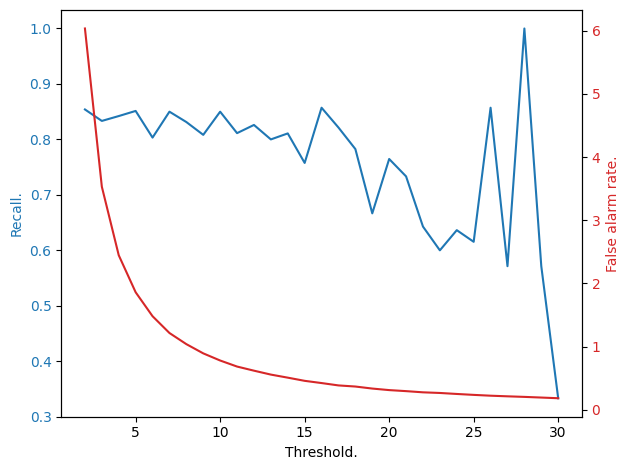

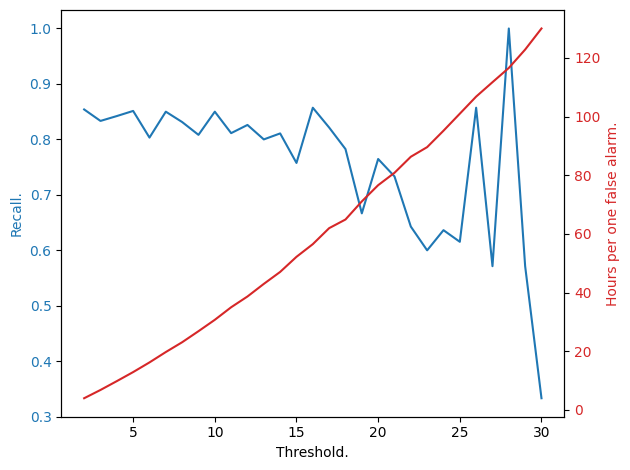

In [4]:
start_threshold = 1
end_threshold = 30
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('False alarm rate.', color=color)
ax2.plot(x[start_threshold:end_threshold], far_list[start_threshold:end_threshold], color=color, label='False alarm rate.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()


start_threshold = 1
end_threshold = 30
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Hours per one false alarm.', color=color)
ax2.plot(x[start_threshold:end_threshold], hpfa_list[start_threshold:end_threshold], color=color, label='Hours per one false alarm.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()

Number of walkings: 172996
Number of falling while walking: 26
Days of falling while walking: {128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301}


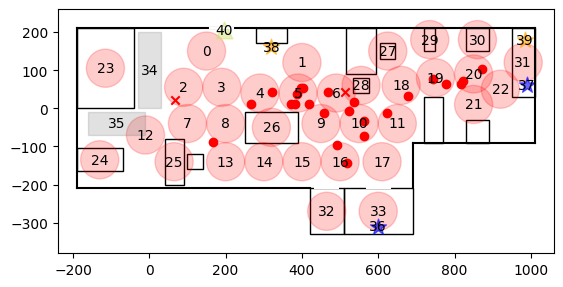

In [15]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_dt[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for p, r in zip(fall_w_points, fall_detection_rate):
    if r >= 0.7:
        success_points.append(p)
    else:
        miss_points.append(p)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

Number of walkings: 172996
Number of falling while walking: 26
Days of falling while walking: {128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301}


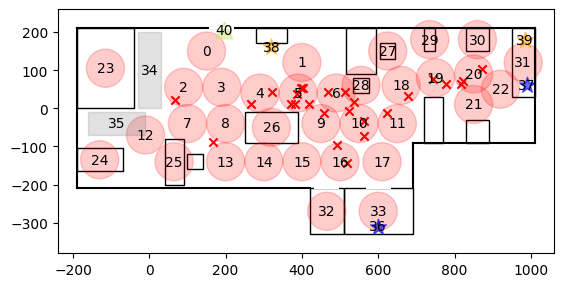

In [14]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_rule = utils.pickle_load(test_path / "experiment", "y_test_rule")
y_pred_rule = utils.pickle_load(test_path / "experiment", "y_pred_rule")

# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_rule)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_rule[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for p, r in zip(fall_w_points, fall_detection_rate):
    if r >= 0.7:
        success_points.append(p)
    else:
        miss_points.append(p)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

In [4]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")

second_threshold = 5
y_test_rule, y_pred_rule = online_detection_rule(test_path,
        data_type = data_type, time_step = time_step, window_len=window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len,second_threshold=second_threshold)
print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule, y_pred_rule))
print("Classification report")
print(classification_report(y_test_rule, y_pred_rule))

Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60023 / 60023. Completed!
Extract fall features. 60026 / 60026. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60032 / 60032. Completed!
Extract fall features. 60030 / 60030. Completed!
Extract fall features. 60036 / 60036. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60027 / 60027. Completed!
Extract fall features. 60037 / 60037. Completed!
Extract fall features. 60039 / 60039. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60018 / 60018. Completed!
Extract fall features. 60028 / 60028. Completed!
Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60021 / 60021. Completed!
Extract fall feature

In [6]:
end = 9*360*24*60*60
start = end - 3*30*24*60*60
y_test_rule_long, y_pred_rule_long = online_detection_rule(test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = (start, end), half_len = half_len)

print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_long, y_pred_rule_long))
print("Classification report")
print(classification_report(y_test_rule_long, y_pred_rule_long))

Extract fall features. 7775999 / 7775999. Completed!
Test error Rule------------------------
Confusion matrix:
[[7775074     898]
 [     17      11]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   7775972
        True       0.01      0.39      0.02        28

    accuracy                           1.00   7776000
   macro avg       0.51      0.70      0.51   7776000
weighted avg       1.00      1.00      1.00   7776000



# Another metrics

In [ ]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")
y_test_rule_long = utils.pickle_load(test_path / "experiment", "y_test_rule_long")
y_pred_rule_long = utils.pickle_load(test_path / "experiment", "y_pred_rule_long")
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

In [6]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
days = 9 * 360
threshold = 10
sensitivity, false_alarm, mean_alarm_length = analysis.original_metrics(y_test_dt_long, y_pred_dt_long, threshold = threshold)
false_alarm_rate = false_alarm / days
print(f"sensitivity: {sensitivity:.2f}, false_alarm_rate [num/day]: {false_alarm_rate:.2f}, "
      f"hours_per_false_alarm [hours/num]: {24 / false_alarm_rate:.2f}, mean_alarm_length: {mean_alarm_length:.2f}")

sensitivity: 0.92, false_alarm_rate [num/day]: 0.21, hours_per_false_alarm [hours/num]: 113.52, mean_alarm_length: 45.40


In [2]:
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_rf_long_new3")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_rf_long_new3")

threshold_max = 40
days = 9 * 360
use_fixed_alarm = False
alarm_length = 5 * 60
thresholds = list(range(1, threshold_max + 1))
sensitivity_list = []
false_alarm_rate_list = []
hours_per_false_alarm_list = []
mean_alarm_length_list = []
for th in thresholds:
    utils.print_progress_bar(threshold_max, th, "Calculating metrics.", 1)
    sensitivity, false_alarm, mean_alarm_length = analysis.original_metrics(y_test_dt_long, y_pred_dt_long, threshold = th,
                                                                            use_fixed_alarm = use_fixed_alarm, alarm_length = alarm_length)
    false_alarm_rate = false_alarm / days
    sensitivity_list.append(sensitivity)
    false_alarm_rate_list.append(false_alarm_rate)
    hours_per_false_alarm_list.append(24 / false_alarm_rate)
    mean_alarm_length_list.append(mean_alarm_length)

for (th, s, far, hpf, mal) in zip(thresholds, sensitivity_list, false_alarm_rate_list, hours_per_false_alarm_list, mean_alarm_length_list):
    print(f"threhold: {th}, sensitivity: {s:.2f}, false_alarm_rate [num/day]: {far:.2f}, "
          f"hours_per_false_alarm [hours/num]: {hpf:.2f}, mean_alarm_length: {mal:.2f}")

Calculating metrics. 40 / 40. Completed!
threhold: 1, sensitivity: 0.98, false_alarm_rate [num/day]: 1.19, hours_per_false_alarm [hours/num]: 20.16, mean_alarm_length: 6.69
threhold: 2, sensitivity: 0.98, false_alarm_rate [num/day]: 0.77, hours_per_false_alarm [hours/num]: 31.10, mean_alarm_length: 9.71
threhold: 3, sensitivity: 0.98, false_alarm_rate [num/day]: 0.44, hours_per_false_alarm [hours/num]: 54.95, mean_alarm_length: 15.39
threhold: 4, sensitivity: 0.98, false_alarm_rate [num/day]: 0.33, hours_per_false_alarm [hours/num]: 72.40, mean_alarm_length: 19.13
threhold: 5, sensitivity: 0.98, false_alarm_rate [num/day]: 0.29, hours_per_false_alarm [hours/num]: 81.85, mean_alarm_length: 20.99
threhold: 6, sensitivity: 0.98, false_alarm_rate [num/day]: 0.28, hours_per_false_alarm [hours/num]: 86.69, mean_alarm_length: 21.88
threhold: 7, sensitivity: 0.98, false_alarm_rate [num/day]: 0.26, hours_per_false_alarm [hours/num]: 93.35, mean_alarm_length: 23.02
threhold: 8, sensitivity: 0.98

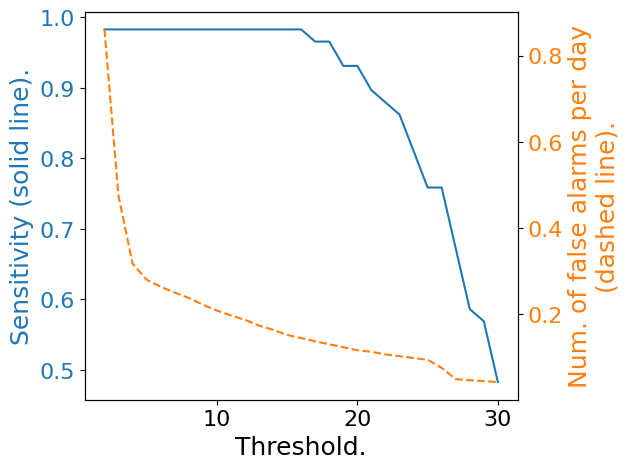

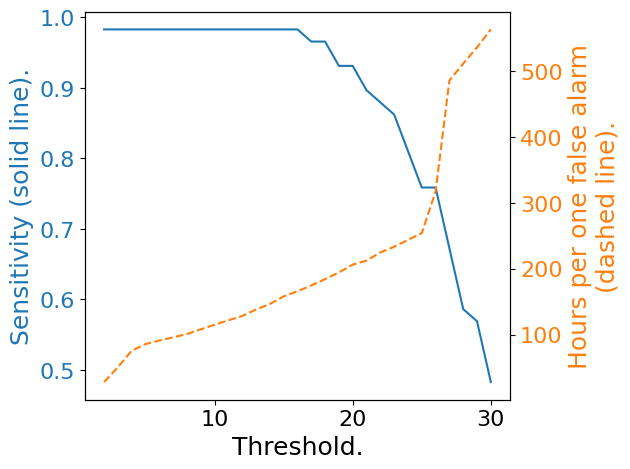

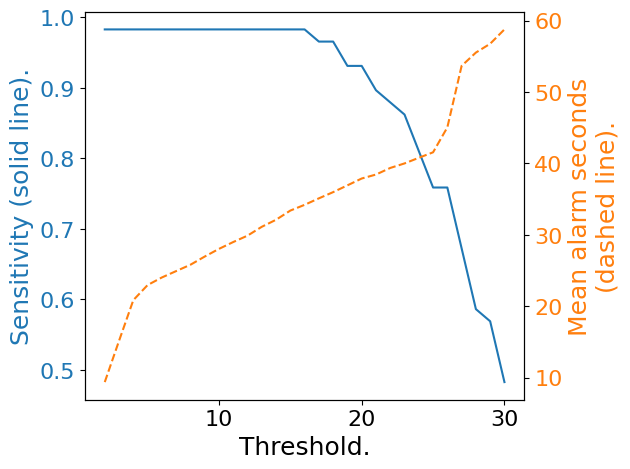

In [3]:
def plot_metrics(x, y1, y2, x_label, y1_label, y2_label, start_threshold, end_threshold, save_title):
    fontsize = 18
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel(x_label, fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize-2) 
    ax1.set_ylabel(y1_label, color=color, fontsize=fontsize)
    ax1.plot(x[start_threshold:end_threshold], y1[start_threshold:end_threshold], color=color, label=y1_label)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=fontsize-2)
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel(y2_label, color=color, fontsize=fontsize)
    ax2.plot(x[start_threshold:end_threshold], y2[start_threshold:end_threshold], color=color, label=y2_label, linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize-2)
    fig.tight_layout()
    plt.savefig(save_title, dpi = 400, bbox_inches="tight")
    plt.show()
    plt.close()

start_threshold = 1
end_threshold = 30
plot_metrics(thresholds, sensitivity_list, false_alarm_rate_list,
             'Threshold.', 'Sensitivity (solid line).', 'Num. of false alarms per day\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-far.png')

plot_metrics(thresholds, sensitivity_list, hours_per_false_alarm_list,
             'Threshold.', 'Sensitivity (solid line).', 'Hours per one false alarm\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-hpfa.png')

plot_metrics(thresholds, sensitivity_list, mean_alarm_length_list,
             'Threshold.', 'Sensitivity (solid line).', 'Mean alarm seconds\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-mal.png')

# How the false prediction occurs

Number of walkings: 172996
Number of falling while walking: 58
Days of falling while walking: {128, 1794, 2946, 135, 392, 1545, 266, 910, 3214, 2067, 1428, 1556, 2451, 1687, 1560, 3097, 283, 1438, 2338, 1699, 548, 3115, 2860, 2481, 434, 567, 1721, 1722, 1849, 2361, 2876, 319, 1216, 1599, 2882, 3141, 2759, 3019, 464, 1490, 1107, 855, 983, 1495, 2139, 1372, 990, 2910, 485, 3046, 2922, 363, 2802, 373, 3193, 2301, 511}
7
25


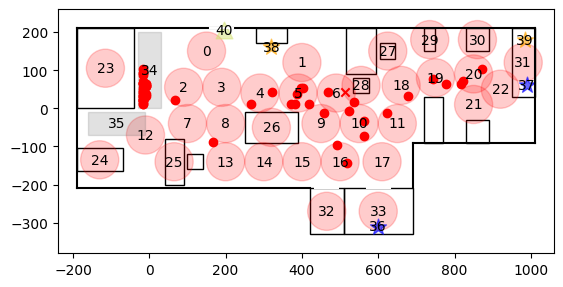

fall_length:[17, 19, 20, 22, 22, 23, 23, 23, 24, 24, 24, 25, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 30, 30, 30, 30, 30, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 38, 38, 39, 39, 39, 39, 40, 41]


In [5]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long_new3")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long_new3")
# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt_long)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
fall_wt = []
fall_index_in_WT= []

pred_intervals = analysis.seq2interval(y_pred_dt_long)
pred_intervals = [x for x in pred_intervals if x[1] - x[0] >= 18]
y_pred_dt_long = np.zeros_like(y_pred_dt_long)
for start, end in pred_intervals:
    y_pred_dt_long[start:end] = True

for i, wt in enumerate(WT):
    if wt.fall_w or wt.fall_s:
        fall_index_in_WT.append(i)
        fall_wt.append(wt)
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_dt_long[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for i, (p, r) in enumerate(zip(fall_w_points, fall_detection_rate)):
    if r > 0:
        success_points.append(p)
    else:
        miss_points.append(p)
        print(i)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

fall_length = [r[1] - r[0] for r in true_regions]
print(f"fall_length:{sorted(fall_length)}")

In [8]:
fall_index = 15
fall_start, fall_end = true_regions[fall_index]
print(fall_start, fall_end)
print(fall_end - fall_start)
print(timedelta(seconds = int(fall_start)), timedelta(seconds = int(fall_end)))
print(fall_w_points[fall_index])
print(fall_wt[fall_index])
print(fall_index_in_WT[fall_index])


AS = utils.pickle_load(test_path, "AS")
print(AS[fall_index_in_WT[fall_index]])
print(AS[fall_index_in_WT[fall_index]+1])

202078165 202078195
30
2338 days, 20:49:25 2338 days, 20:49:55
(67.5, 22.5)
<WalkingTrajectory> type: Direct from Sofa (2338 days, 20:49:21.975456) to Wardrobe (2338 days, 20:49:57.349032)
124440
<ActivityDataPoint> <Activity>Watch TV from 2338 days, 20:14:24.023581 to 2338 days, 20:49:57.349032 at Sofa
<ActivityDataPoint> <Activity>Change clothes from 2338 days, 20:49:57.349032 to 2338 days, 20:56:23.235286 at Wardrobe


In [10]:
# start = 129225046
# end = 129225081
# start = 202078165
# end = 202078195
start = fall_start
end = fall_end
width = 60*60*24

path = layout_database_path / "test_layout" / "test_data_5"
SD_model = utils.pickle_load(path, "SD_model")
SD = utils.pickle_load(path / "experiment", f"SD_mat_raw_1")
SD_names = utils.pickle_load(path / "experiment", "SD_names")

# extract motion sensor data
motion_sensor_indexes = []
for i, s_i in enumerate(SD_names):
    if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
        motion_sensor_indexes.append(i)
SD = SD[start - width: end + width, motion_sensor_indexes]

# extract features of non response time
X = fall_feature_sliding(SD, time_step=1, window_len=5, nrt_type="max")
print(X.shape)

Extract fall features. 172829 / 172829. Completed!
(172830, 36)


In [20]:
print(SD[width])

[False False  True False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False]


In [23]:
for x in gen_fall_feature_sliding(SD[width:width + end - start], time_step=1, window_len=60, nrt_type = "instantaneous"):
    print(x)

[False False  True False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False]
-------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False]
-------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False]
-------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[False False False False False False False False False False False False
 False False False Fa

In [11]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")
# analysis.print_positive_path(decision_tree)
analysis.print_decision_path(decision_tree, X[width:width + end - start])

Sample 0: (X[0](0.00) <= 0.50) and (X[1](0.00) <= 0.50) and (X[3](0.00) <= 0.50) and (X[4](0.00) <= 0.50) and (X[5](0.00) <= 1.50) and (X[6](0.00) <= 0.50) and (X[7](0.00) <= 3.50) and (X[8](0.00) <= 0.50) and (X[9](0.00) <= 0.50) and (X[10](0.00) <= 3.50) and (X[12](0.00) <= 0.50) and (X[13](0.00) <= 1.50) and (X[14](0.00) <= 1.50) and (X[15](0.00) <= 0.50) and (X[16](0.00) <= 25.50) and (X[17](0.00) <= 0.50) and (X[18](0.00) <= 0.50) and (X[19](0.00) <= 0.50) and (X[21](0.00) <= 1.50) and (X[22](0.00) <= 0.50) and (X[24](0.00) <= 12.50) and (X[25](0.00) <= 0.50) and (X[26](0.00) <= 37.50) and (X[27](0.00) <= 15.50) and (X[28](0.00) <= 10.50) and (X[29](0.00) <= 0.50) and (X[30](0.00) <= 0.50) and (X[31](0.00) <= 0.50) and (X[33](0.00) <= 1.50) and (X[34](0.00) <= 1.50) and (X[35](0.00) <= 0.50), predict False
Sample 1: (X[0](0.00) <= 0.50) and (X[1](0.00) <= 0.50) and (X[3](0.00) <= 0.50) and (X[4](0.00) <= 0.50) and (X[5](0.00) <= 1.50) and (X[6](0.00) <= 0.50) and (X[7](0.00) <= 3.

In [6]:
analysis.print_positive_path(decision_tree)

(X[0] <= 2.50) and (X[1] <= 0.50) and (X[3] <= 0.50) and (X[4] <= 0.50) and (X[5] <= 2.50) and (X[6] <= 0.50) and (X[7] <= 3.50) and (X[8] <= 0.50) and (X[9] <= 0.50) and (X[10] <= 3.50) and (X[12] <= 0.50) and (X[13] <= 1.50) and (X[14] <= 1.50) and (X[15] <= 0.50) and (X[16] <= 25.50) and (X[17] <= 0.50) and (X[18] <= 1.50) and (X[19] <= 0.50) and (X[21] <= 1.50) and (716.50 < X[26]) and (1.50 < X[28]) and (X[33] <= 2.50) and (X[34] <= 1.50)
(X[0] <= 4.50) and (X[1] <= 0.50) and (X[3] <= 1.50) and (X[4] <= 3.50) and (X[5] <= 3.50) and (X[6] <= 0.50) and (X[7] <= 3.50) and (X[8] <= 0.50) and (X[9] <= 0.50) and (X[10] <= 3.50) and (X[12] <= 3.50) and (X[13] <= 1.50) and (X[14] <= 3.50) and (X[15] <= 3.50) and (X[17] <= 3.50) and (X[18] <= 1.50) and (2.50 < X[19] <= 3.50) and (1.50 < X[20]) and (1.50 < X[21] <= 3.50) and (X[29] <= 1.50) and (X[30] <= 2374.50) and (X[33] <= 3.50) and (X[34] <= 3.50)
(X[0] <= 4.50) and (X[1] <= 0.50) and (X[3] <= 1.50) and (X[4] <= 3.50) and (X[5] <= 3.50

In [30]:
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_rule5_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_rule5_long")
# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt_long)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0

true_intervals = analysis.seq2interval(y_test_dt_long)
pred_intervals = analysis.seq2interval(y_pred_dt_long)
pred_intervals = [x for x in pred_intervals if x[1] - x[0] >= 18]
false_indexes = []

for i, (pred_start, pred_end) in enumerate(pred_intervals):
    overlap = False
    for true_start, true_end in true_intervals:
        if pred_start <= true_end and true_start <= pred_end:
            overlap = True
            break
    if not overlap:
        false_indexes.append(i)
print(false_indexes)
print(len(false_indexes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 22

In [31]:
path = layout_database_path / "test_layout" / "test_data_5"
SD_model = utils.pickle_load(path, "SD_model")
SD = utils.pickle_load(path / "experiment", f"SD_mat_raw_1")
SD_names = utils.pickle_load(path / "experiment", "SD_names")

# extract motion sensor data
motion_sensor_indexes = []
for i, s_i in enumerate(SD_names):
    if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
        motion_sensor_indexes.append(i)
SD = SD[:, motion_sensor_indexes]
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")

In [32]:
# analysis.print_positive_path(decision_tree)
index = 0
r = pred_intervals[index]
start, end = r[0], r[1]
print(start, end)
width = 60 * 60 * 10
# extract features of non response time
X = fall_feature_sliding(SD[start - width: end + width], time_step=1, window_len=5, nrt_type="max")
analysis.print_decision_path(decision_tree, X[width:width + end - start + 20])

113336 113358
Extract fall features. 72021 / 72021. Completed!
Sample 0: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X[13](0.00) <= 3.50) and (X[14](0.00) <= 3.50) and (4.50 < X[15](7.00)) and (X[18](0.00) <= 3.50) and (X[21](0.00) <= 3.50) and (0.50 < X[31](4.00)), predict False
Sample 1: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X[13](0.00) <= 3.50) and (X[14](0.00) <= 3.50) and (4.50 < X[15](8.00)) and (X[18](0.00) <= 3.50) and (X[21](0.00) <= 3.50) and (0.50 < X[31](5.00)), predict False
Sample 2: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X[13](0.00) <= 3.50) and (X[14](0.00) <= 3.50) and (4.50 < X[15](9.00)) and (X[18](0.00) <= 3.50) and (X[21](0.00) <= 3.50) and (0.50 < X[31](6.00)), predict False
Sample 3: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X

In [34]:
AS = utils.pickle_load(test_path, "AS")
t = timedelta(seconds = int(r[0]))
print(t)
for i, act in enumerate(AS):
    if act.start <= t <= act.end:
        print(i)
        break
print(AS[i-1])
print(AS[i])

1 day, 7:28:56
57
<ActivityDataPoint> <Activity>Rest from 1 day, 7:25:52.367565 to 1 day, 7:28:55.226910 at Sofa
<ActivityDataPoint> <Activity>Urination from 1 day, 7:28:55.226910 to 1 day, 7:32:08.578282 at Toilet_Door


In [20]:
mean, std = 5, 5
mean2 = np.log(mean**2/np.sqrt(mean**2+std**2))
std2 = np.sqrt(np.log(1 + std**2/mean**2))
mean, std = mean2, std2
print(mean, std)

from scipy.stats import norm
x_value = 1
F_x = norm.cdf(-mean/std)
print(F_x)


1.2628643221541276 0.8325546111576977
0.06465169448402877


In [23]:
fall_days = [128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301]
for i in range(9):
    start = i * 360
    end = (i+1) * 360
    num = len([d for d in fall_days if start <= d < end])
    print(f"{i} - {i+1}: {num}")

0 - 1: 2
1 - 2: 2
2 - 3: 2
3 - 4: 1
4 - 5: 5
5 - 6: 2
6 - 7: 3
7 - 8: 4
8 - 9: 5
